# Dataset Drilldown

Show various statistics about the dataset.

In [1]:
import os
print(os.getcwd())

/home/yotamfr/development/prot2vec/src/python


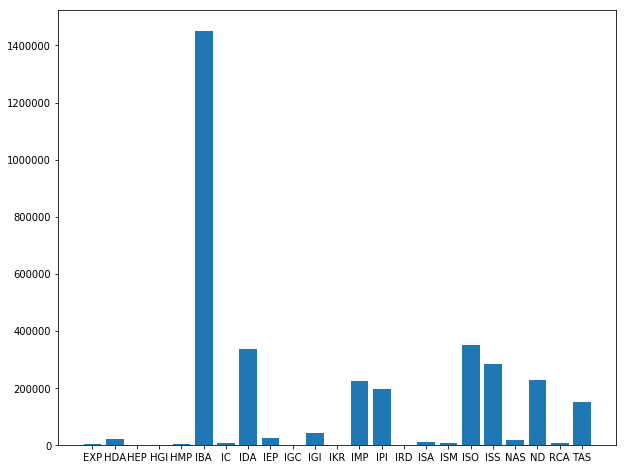

EXP	:	3746
HDA	:	19244
HEP	:	301
HGI	:	136
HMP	:	1757
IBA	:	1452063
IC	:	7505
IDA	:	336994
IEP	:	24411
IGC	:	443
IGI	:	43090
IKR	:	239
IMP	:	225113
IPI	:	195375
IRD	:	33
ISA	:	9636
ISM	:	5380
ISO	:	348465
ISS	:	282522
NAS	:	17967
ND	:	227951
RCA	:	4718
TAS	:	148534
Total	:	3355623
100%
Finished loading 331376 mappings!
100%
Finished loading 87866 sequences!


In [2]:
%matplotlib inline  
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np

from src.python.preprocess import *

from pymongo import MongoClient

client = MongoClient("mongodb://127.0.0.1:27017")
# client = MongoClient("mongodb://192.168.1.14:27017")

db = client['prot2vec']
goa_collection = db.goa_uniprot

q = {'Evidence': {'$in': exp_codes}, 'DB': 'UniProtKB'} 
num_go = goa_collection.count(q)
src_go = goa_collection.find(q)


def bar_plot_with_labels(data, labels):
    indx = range(1, len(data)+1)
    plt.bar(indx, data, align='center')
    plt.xticks(indx, labels)
    plt.show()
    
def pretty_print(codes, counts):
    hist = list(zip(codes, counts))
    for code, c in hist: 
        print("%s\t:\t%d" % (code, c))
    print("Total\t:\t%d" % sum(map(lambda x: x[1], hist)))

codes = goa_collection.distinct('Evidence')
counts = list(map(lambda c: goa_collection.count({'Evidence': {'$in': [c]}}), codes))
bar_plot_with_labels(counts, codes)
pretty_print(codes, counts)

# dbs = db.goa_uniprot.distinct('DB')
# counts = list(map(lambda d: db.goa_uniprot.count({'DB': d}), dbs))
# bar_plot_with_labels(counts, dbs)
# pretty_print(dbs, counts)

seqid2goid, goid2seqid = GoAnnotationCollectionLoader(src_go, num_go, 'P').load()

query = {"_id": {"$in": unique(list(seqid2goid.keys())).tolist()}}
num_seq = db.uniprot.count(query)
src_seq = db.uniprot.find(query)

seqid2seq = UniprotCollectionLoader(src_seq, num_seq).load()


### Label distribution

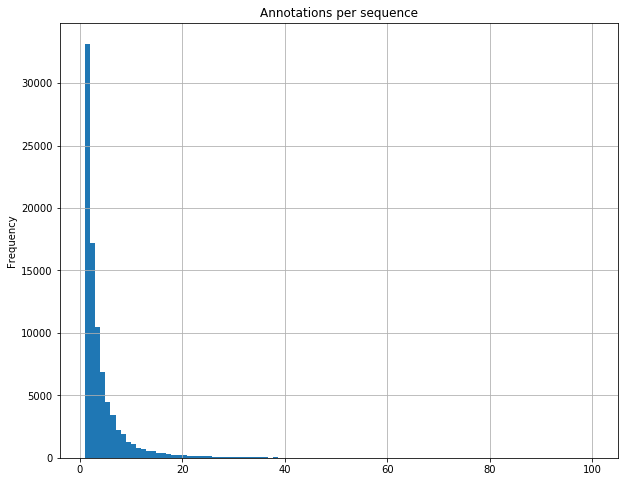

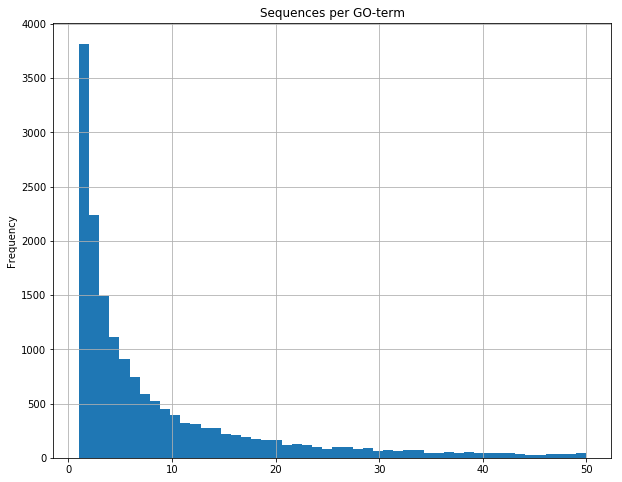

In [3]:
plt.hist(list(map(lambda annos: len(annos), seqid2goid.values())), bins=100, range=(1, 100))
plt.title("Annotations per sequence")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.hist(list(map(lambda seqs: len(seqs), goid2seqid.values())), bins=50, range=(1, 50))
plt.title("Sequences per GO-term")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Create the dataset

In [4]:
onto = get_ontology('P')
dataset = Dataset(seqid2seq, seqid2goid, onto)
print(dataset)
p99 = np.percentile(list(map(lambda r: len(r.seq), dataset.records)), 99)
print("99 percentile:\t%d" % p99)


#Annotaions	331376
#GO-Terms	17827
#Sequences	87866
99 percentile:	2819


### Sequence length statistics


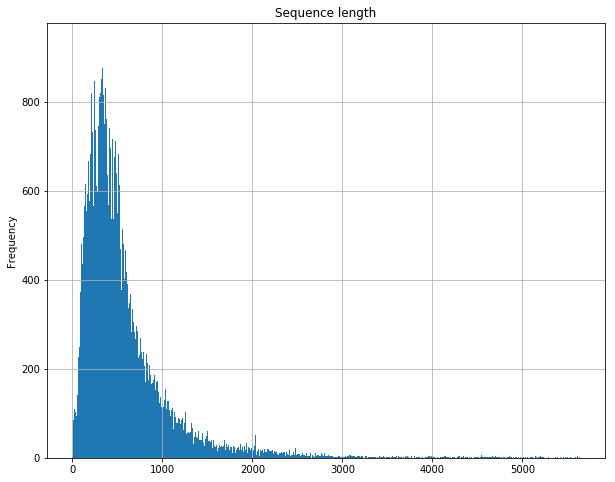

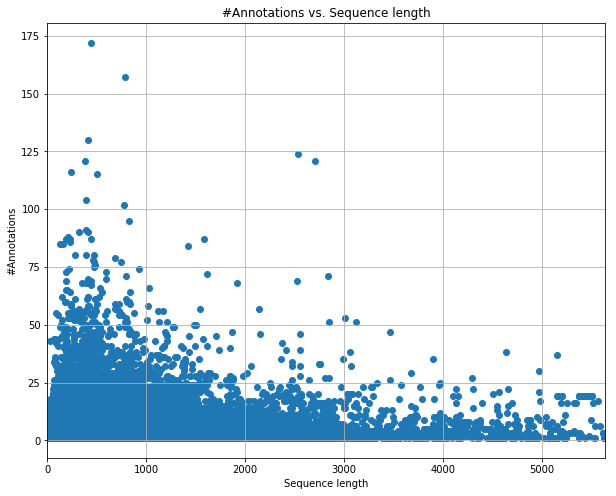

In [5]:
plt.hist(list(map(lambda r: len(r.seq), dataset.records)), bins=1000, range=(0, p99 * 2))
plt.title("Sequence length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# pnts = np.random.choice(dataset.records, 5000, replace=False)
pnts = dataset.records

x = list(map(lambda r: len(r.seq), pnts))
y = list(map(lambda r: len(r.lbl), pnts))
plt.scatter(x, y)
plt.xlim(0, 2 * p99)
plt.title("#Annotations vs. Sequence length")
plt.xlabel("Sequence length")
plt.ylabel("#Annotations")
plt.grid(True)
plt.show()


### Load GeneOntology

In [6]:
from src.python.geneontology import *
go_graph = initialize_go()

assert nx.is_directed_acyclic_graph(go_graph)

### Dataset augmentation

In [7]:
attr = go_graph._node

def pretty(labels):
    return '\n'.join(["%s\t%s" % (lbl, attr[lbl]['name']) for lbl in labels])

print("\n--------------> leaf-only\n")
print(dataset)
print("\n")
record = dataset.records[0]
print(pretty(record.lbl))



--------------> leaf-only


#Annotaions	331376
#GO-Terms	17827
#Sequences	87866


GO:0045892	negative regulation of transcription, DNA-templated


### Show GO Labels and SubGraph

100%
--------------> augmented


#Annotaions	4108535
#GO-Terms	21316
#Sequences	87866


GO:0065007	biological regulation
GO:0050789	regulation of biological process
GO:0050794	regulation of cellular process
GO:0019222	regulation of metabolic process
GO:0031323	regulation of cellular metabolic process
GO:0051171	regulation of nitrogen compound metabolic process
GO:0060255	regulation of macromolecule metabolic process
GO:0080090	regulation of primary metabolic process
GO:0048519	negative regulation of biological process
GO:0009892	negative regulation of metabolic process
GO:0048523	negative regulation of cellular process
GO:0031324	negative regulation of cellular metabolic process
GO:0010605	negative regulation of macromolecule metabolic process
GO:0051172	negative regulation of nitrogen compound metabolic process
GO:0010468	regulation of gene expression
GO:0010629	negative regulation of gene expression
GO:0009889	regulation of biosynthetic process
GO:0010556	regulation of macromolecule 

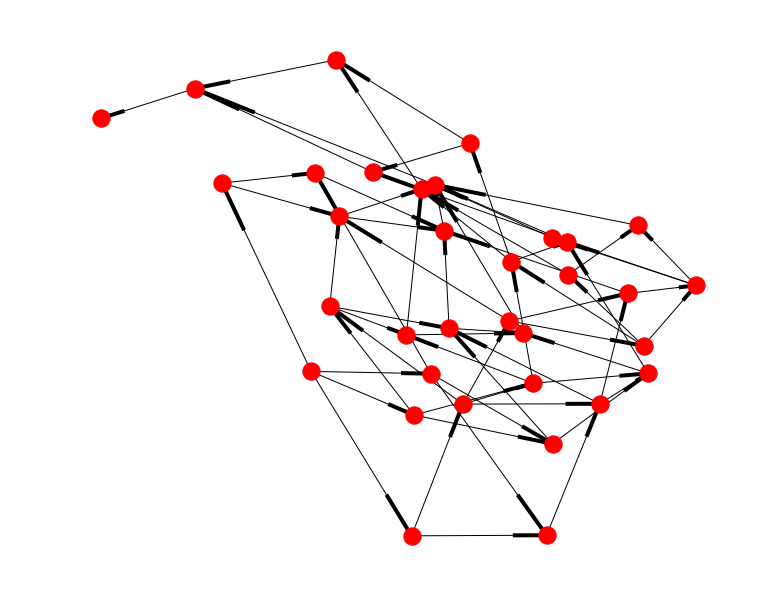

In [8]:
dataset.augment()

print("\n--------------> augmented\n")
print(dataset)
print("\n")
record = dataset.records[0]
print(pretty(record.lbl))
                     
sub_graph = go_graph.subgraph(record.lbl)
nx.draw(sub_graph)
plt.show()

In [9]:
_, seqid2goid = Dataset.to_dictionaries(dataset.records)

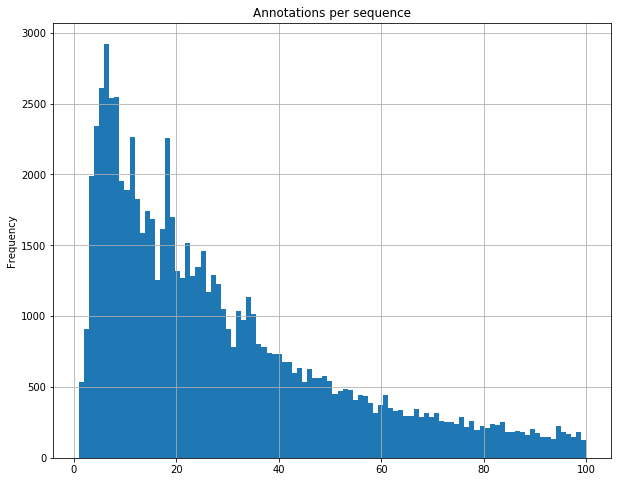

In [17]:
plt.hist(list(map(lambda annos: len(annos), seqid2goid.values())), bins=100, range=(1, 100))
plt.title("Annotations per sequence")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [11]:
from preprocess2 import *

In [15]:
def get_random_training_and_validation_streams(db, asp, profile=False):
    Stream = ProfileStream if profile else SequenceStream
    collection = db.pssm if profile else db.uniprot
    q_valid = {'DB': 'UniProtKB', 'Evidence': {'$in': exp_codes}, 'Aspect': asp}
    seq2go, _ = GoAnnotationCollectionLoader(db.goa_uniprot.find(q_valid),
                                             db.goa_uniprot.count(q_valid), asp).load()
    seq2go_tst = {k: seq2go[k] for k in np.random.choice(list(seq2go.keys()), size=len(seq2go)//5)}
    seq2go_trn = {k: v for k, v in seq2go.items() if k not in seq2go_tst}
    stream_tst = Stream(seq2go_tst, collection)
    stream_trn = Stream(seq2go_trn, collection)
    return stream_trn, stream_tst

trn_stream, tst_stream = get_random_training_and_validation_streams(db, 'F')


100%
Finished loading 133167 mappings!


In [22]:
(len(tst_stream._seq2go), len(trn_stream._seq2go), len(set([k for k in tst_stream._seq2go]) & set([k for k in trn_stream._seq2go])))

(12466, 56331, 0)

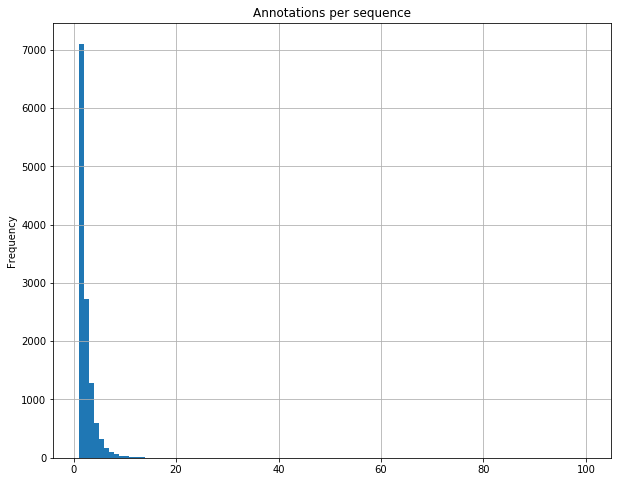

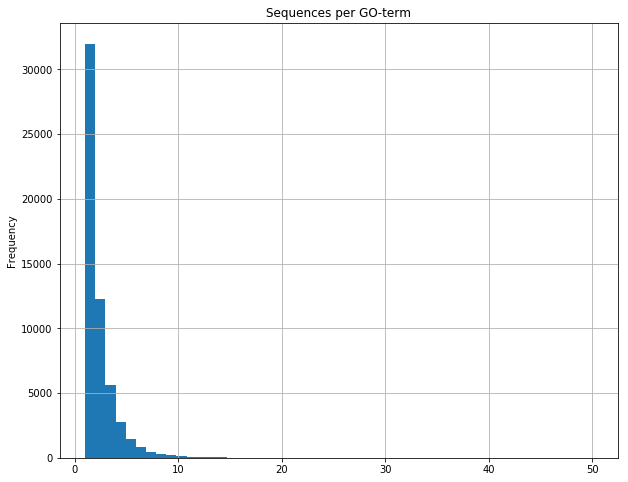

In [23]:
plt.hist(list(map(lambda annos: len(annos), tst_stream._seq2go.values())), bins=100, range=(1, 100))
plt.title("Annotations per sequence")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.hist(list(map(lambda seqs: len(seqs), trn_stream._seq2go.values())), bins=50, range=(1, 50))
plt.title("Sequences per GO-term")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
